# **Step 1: Indicating the imported packages/libraries**

In [2]:
# Importing all the libraries required for creating MLP and CNN
import pandas as pd
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, RandomRotation, RandomHorizontalFlip,  RandomVerticalFlip, ToPILImage
import torchvision.transforms.functional as TF
# Checking if using GPU or the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Currently using:", device)

Currently using: cuda


In [3]:
"""
    - Creating EMNISTDataset class for loading the data set and converting the CSV to tensors
    - Basic functions for data set visualization
"""

class EMNISTDataset(Dataset):


    def __init__(self, image_data_path, mapping_data_path, transform = None, target_transform = None):

        self.image_data_df = pd.read_csv(image_data_path,  header = None)
        #self.image_data_df[0] = self.image_data_df[0].astype(int)
        #self.test_df = pd.read_csv(test_image_data_path)
        self.label_map = pd.read_csv(mapping_data_path, delimiter = '\t')
        self.transform = self.create_transform()

        label_map = pd.read_csv(mapping_data_path,
                        delimiter = ' ',
                        index_col=0,
                        header=None
                       )
        label_map=label_map.reset_index(drop=True)
        label_map.columns=["col"]
            #Initialising an empty dictionary
        label_dictionary = {}

        #Running a loop for ASCII equivalent to character conversion
        for index, label in enumerate(label_map.col):
            label_dictionary[index] = chr(label)
        self.label_dictionary = label_dictionary

    def __getitem__(self, idx):

        sample_row = self.image_data_df.iloc[idx]
        #print(sample_row)
        sample_label = sample_row[0]
        #print(sample_label)
        W = 28
        H = 28
        sample_img = sample_row[1:].values.reshape(W, H).astype(np.float32)
        #print(sample_img)
        sample_label = sample_label
        sample_img = self.transform(sample_img)
        ## the data needs to be loaded here only and that too just for
        ## the idx. The entire data is never loaded into memory
        ## this is lazy loading concept of Datasets class
        #x_train = np.apply_along_axis(flip_and_rotate, 1, x_train.values)
        #x_train.shape

        return sample_img, sample_label

    def __len__(self):
        return self.image_data_df.shape[0]


    def create_transform(self):

        transforms = CustomTransform(90.0)
        return transforms

class CustomTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, image):
        image = TF.rotate(TF.hflip(TF.to_tensor(image)), self.angle)
        return image

# **Step 2/3: Loading the Data set using Pandas and splitting them in Test and Train**

In [4]:
# Unable to lad data directly from torch hence I uploaded the data sets to Google colab
# and then using them through Pandas Data fram

# Reading the training and testing data using Pandas
training_data_path = '/content/emnist-balanced-train.csv'
test_data_path = '/content/emnist-balanced-test.csv'
mapping_data_path = "/content/emnist-balanced-mapping.txt"
label_map = pd.read_csv(mapping_data_path,delimiter = ' ',index_col=0,header=None)
emnist_train_total = EMNISTDataset(image_data_path = training_data_path, mapping_data_path = mapping_data_path, transform = None, target_transform = None)
emnist_test = EMNISTDataset(image_data_path = test_data_path, mapping_data_path = mapping_data_path, transform = None, target_transform = None)


# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(emnist_train_total))
val_size = len(emnist_train_total) - train_size
emnist_train, emnist_val = torch.utils.data.random_split(emnist_train_total, [train_size, val_size])

# Create the dataloaders for the training, validation, and testing datasets
train_loader = DataLoader(emnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(emnist_test, batch_size=128, shuffle=True)
val_loader = DataLoader( emnist_val, batch_size=128, shuffle=False)




# **Step 4: Visualizing and Understanding the Dataset**

Step 4.1: Print out the count of Testing/Training samples

In [5]:
# Print out the number of training and testing samples
print(f'Number of training samples (including Validation data): {len(emnist_train_total)}')
print(f'Number of testing samples: {len(emnist_test)}')

Number of training samples (including Validation data): 112800
Number of testing samples: 18800


Step 4.2: Visualize some samples of Dataset

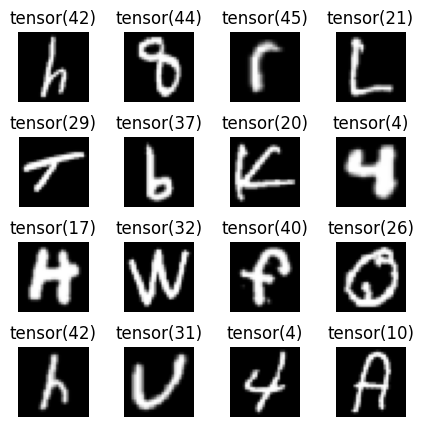

In [6]:
# Defining a function to get images from the dataset
def plot(images, labels):
    fig, axs = plt.subplots(4, 4, figsize=(5, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
    axs = axs.flatten()
    for i in range(len(axs)):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(labels[i])
        axs[i].axis('off')

# Plot sample images from the training dataset
images, labels = next(iter(train_loader))
plot(images, labels)

# **# Step 5: Building MLP and CNN**

Defining the MLP model and hyperparameters

In [7]:
"""
    - Defining class for MLP
    - Used checks for 3 activation functions ReLu, Leaky ReLu, Elu
    - Input Params: Sizes of Input, Output and Hidden layers, Count of hidden layers and Act function
"""
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers_count, hidden_size, activation_function):
        super(MLP, self).__init__()
        layers = []
        for i in range(hidden_layers_count):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            # Checks if activation function is  Relu
            if activation_function == "relu":
                layers.append(nn.ReLU())
            # Checks if activation function is  Leaky Relu
            elif activation_function == "leaky_relu":
                layers.append(nn.LeakyReLU())
            # Checks if activation function is  Elu
            elif activation_function == "elu":
                layers.append(nn.ELU())
            else:
                raise ValueError("Invalid activation function.")
            # Dropout to overcome over fitting
            layers.append(nn.Dropout(p=0.2))
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
    # A feed forward function for output classification
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)

Train the MLP model and choose the best hyperparameters

In [8]:
"""
    Train the model on the training dataset and evaluate its performance.

    Args:
        model (nn.Module): The model to be trained
        train_loader (DataLoader): The dataloader for the training data
        criterion: The loss function
        optimizer: The optimizer for the model
        scheduler: The learning rate scheduler
        num_epochs (int): The number of epochs to train the model

    Returns:
        model, losses, train_accs and test_accs
"""


def train_MLP(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_loss = np.inf
    best_acc = 0
    losses = []
    train_accs = []
    test_accs = []
    # Running each Epoch
    for epoch in range(epochs):
        running_loss = 0
        correct = 0
        total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        losses.append(train_loss)
        train_accs.append(train_acc)

        test_acc, _ = evaluate_MLP(model, test_loader)
        test_accs.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_loss = train_loss
            best_epoch = epoch
    #Getting the Best Accuracy and losses
    print('Best accuracy: {:.4f}, Best loss: {:.4f}, Best epoch: {}'.format(
        best_acc, best_loss, best_epoch))
    return model, losses, train_accs, test_accs

Evaluate the MLP model on the testing set

In [9]:
"""
    - Model evaluation for MLP
    - Performance metrics : Accuracy, Precision, Recall, F1-score
"""

def evaluate_MLP(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted')
    #Print Performance Metrics
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1_score))
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm

Define the CNN model and hyperparameters

In [10]:
"""
    - Defining class for CNN
    - Convoluting and Maxpooling before input to the network
    - Activation function considered Relu
"""
class CNN(nn.Module):
    def __init__(self,output_size):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(inplace=True)) #32*28*28
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2)) #64*14*14
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #64*14*14
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True)) #128*14*14
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2)) #256*7*7
        self.res2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #256*7*7
        self.classifier = nn.Sequential(nn.Flatten(),
                          nn.Linear(256*7*7, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 256),
                          nn.ReLU(),
                          nn.Linear(256, output_size)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Train the CNN model and choose the best hyperparameters

In [11]:
def train_CNN(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_loss = np.inf
    best_acc = 0
    losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        running_loss = 0
        correct = 0
        total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        losses.append(train_loss)
        train_accs.append(train_acc)

        test_acc, _ = evaluate_CNN(model, test_loader)
        test_accs.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_loss = train_loss
            best_model = model.state_dict()

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'.format(
            epoch+1, epochs, train_loss, train_acc, test_acc))

    model.load_state_dict(best_model)
    return best_acc, best_loss, losses, train_accs, test_accs


Evaluate the CNN model on the testing set

In [12]:
def evaluate_CNN(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted')
    # Print performance metrics
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1_score))
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm

In [13]:
# Train MLP model
input_size = 28*28
output_size = len(label_map)
hidden_layers = 3
hidden_size = 256
activation = "relu"

mlp_model = MLP(input_size, output_size,
                hidden_layers, hidden_size, activation)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
epochs = 10

start_time = time.time()
mlp_model, mlp_losses, mlp_train_accs, mlp_test_accs = train_MLP(
    mlp_model, train_loader, test_loader, optimizer, criterion, epochs)
mlp_training_time = time.time() - start_time


Accuracy: 0.7227
Precision: 0.7294
Recall: 0.7227
F1-score: 0.7133
Accuracy: 0.7526
Precision: 0.7597
Recall: 0.7526
F1-score: 0.7459
Accuracy: 0.7646
Precision: 0.7764
Recall: 0.7646
F1-score: 0.7600
Accuracy: 0.7734
Precision: 0.7816
Recall: 0.7734
F1-score: 0.7660
Accuracy: 0.7832
Precision: 0.7855
Recall: 0.7832
F1-score: 0.7805
Accuracy: 0.7857
Precision: 0.7966
Recall: 0.7857
F1-score: 0.7803
Accuracy: 0.7852
Precision: 0.7913
Recall: 0.7852
F1-score: 0.7797
Accuracy: 0.7812
Precision: 0.7886
Recall: 0.7812
F1-score: 0.7717
Accuracy: 0.7954
Precision: 0.8010
Recall: 0.7954
F1-score: 0.7918
Accuracy: 0.7807
Precision: 0.7867
Recall: 0.7807
F1-score: 0.7743
Best accuracy: 0.7954, Best loss: 0.8301, Best epoch: 8


Step 5.2 - After obtaining the best version of the models

In [ ]:
# Train CNN model
input_channels = 1
output_size = len(label_map)
hidden_layers = 3
hidden_channels = 32
kernel_size = 3
pool_size = 2
activation = "relu"

cnn_model = CNN(output_size)
cnn_model.to(device)

# Entropy Criterian and Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
epochs = 10

start_time = time.time()
cnn_best_acc, cnn_best_loss, cnn_losses, cnn_train_accs, cnn_test_accs = train_CNN(
    cnn_model, train_loader, test_loader, optimizer, criterion, epochs)
cnn_training_time = time.time() - start_time

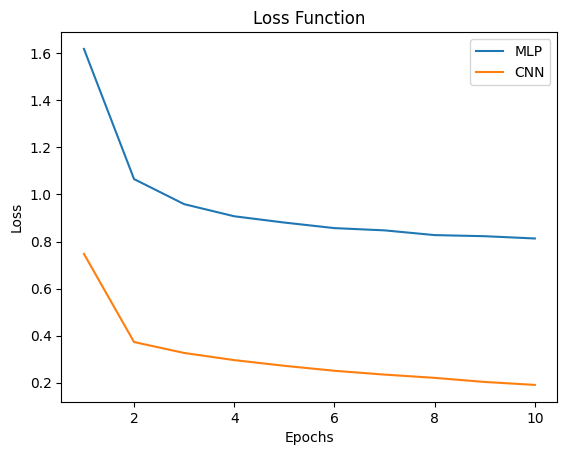

In [ ]:
# Step 5.2.A Plot loss function graph
plt.plot(range(1, epochs+1), mlp_losses, label='MLP')
plt.plot(range(1, epochs+1), cnn_losses, label='CNN')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

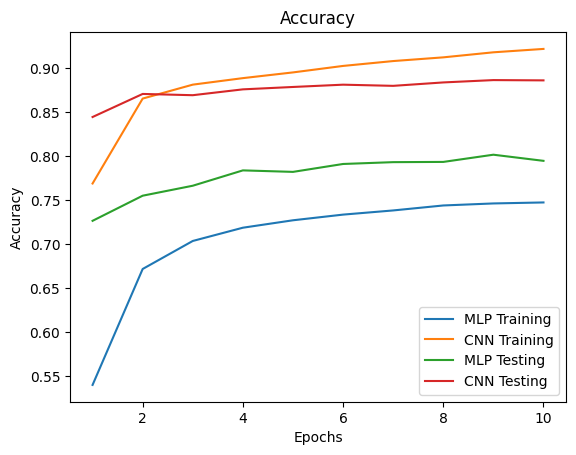

In [ ]:
# Step 5.2.B Plot accuracy graph
plt.plot(range(1, epochs+1), mlp_train_accs, label='MLP Training')
plt.plot(range(1, epochs+1), cnn_train_accs, label='CNN Training')
plt.plot(range(1, epochs+1), mlp_test_accs, label='MLP Testing')
plt.plot(range(1, epochs+1), cnn_test_accs, label='CNN Testing')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Step 5.2.C Print training time

print("MLP training time: {:.2f} seconds".format(mlp_training_time))
print("CNN training time: {:.2f} seconds".format(cnn_training_time))

MLP training time: 630.70 seconds
CNN training time: 921.78 seconds


Step 6.1 - Compare the performance of the MLP and CNN models

In [ ]:
'''# Initialize the MLP model

mlp_model = MLP(input_size=28*28, output_size=len(label_map),
                hidden_layers=2, hidden_size=128, activation="relu").to(device)

# Define the loss function and optimizer for the MLP model

mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Train the MLP model

mlp_model, mlp_losses, mlp_train_accs, mlp_test_accs = train_MLP(
    mlp_model, train_loader, test_loader, mlp_optimizer, mlp_criterion, epochs=10)'''

TypeError: MLP.__init__() got an unexpected keyword argument 'hidden_layers'

In [ ]:
# Initialize the CNN model

cnn_model = CNN(output_size=len(label_map)).to(device)

# Define the loss function and optimizer for the CNN model

cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN model

cnn_acc, cnn_loss, cnn_losses, cnn_train_accs, cnn_test_accs = train_CNN(
    cnn_model, train_loader, test_loader, cnn_optimizer, cnn_criterion, epochs=10)


Accuracy: 0.8522
Precision: 0.8574
Recall: 0.8522
F1-score: 0.8524
Epoch [1/10], Train Loss: 0.7388, Train Acc: 0.7720, Test Acc: 0.8522
Accuracy: 0.8588
Precision: 0.8680
Recall: 0.8588
F1-score: 0.8562
Epoch [2/10], Train Loss: 0.3703, Train Acc: 0.8664, Test Acc: 0.8588
Accuracy: 0.8599
Precision: 0.8667
Recall: 0.8599
F1-score: 0.8567
Epoch [3/10], Train Loss: 0.3204, Train Acc: 0.8818, Test Acc: 0.8599
Accuracy: 0.8798
Precision: 0.8841
Recall: 0.8798
F1-score: 0.8781
Epoch [4/10], Train Loss: 0.2927, Train Acc: 0.8907, Test Acc: 0.8798
Accuracy: 0.8766
Precision: 0.8823
Recall: 0.8766
F1-score: 0.8746
Epoch [5/10], Train Loss: 0.2727, Train Acc: 0.8956, Test Acc: 0.8766
Accuracy: 0.8780
Precision: 0.8862
Recall: 0.8780
F1-score: 0.8768
Epoch [6/10], Train Loss: 0.2519, Train Acc: 0.9028, Test Acc: 0.8780
Accuracy: 0.8852
Precision: 0.8873
Recall: 0.8852
F1-score: 0.8841
Epoch [7/10], Train Loss: 0.2369, Train Acc: 0.9071, Test Acc: 0.8852
Accuracy: 0.8857
Precision: 0.8884
Recall

Step 6.2 - Print the prediction of the top six samples in the testing dataset

In [ ]:
'''# Set the model to evaluation mode

mlp_model.eval()
cnn_model.eval()

# Get the top six samples from the testing dataset

top_six = test_data_path[:6]

# Make predictions using the MLP model

mlp_preds = []
for image,label in top_six:
  image = image.unsqueeze(0).to(device)
  output = mlp_model(image)
  _, predicted = torch.max(output.data, 1)
  mlp_preds.append(predicted.item())

# Make predictions using the CNN model

cnn_preds = []
for image, label in top_six:
  image = image.unsqueeze(0).unsqueeze(0).to(device)
  output = cnn_model(image)
  _, predicted = torch.max(output.data, 1)
  cnn_preds.append(predicted.item())

# Print the predictions

print("MLP model predictions:", [mapping[pred] for pred in mlp_preds])
print("CNN model predictions:", [mapping[pred] for pred in cnn_preds])'''

ValueError: not enough values to unpack (expected 2, got 1)

Step 6.3 - Plot the confusion matrix of two models – MLP and CNNs

Accuracy: 0.7944
Precision: 0.7993
Recall: 0.7944
F1-score: 0.7898
Accuracy: 0.8879
Precision: 0.8912
Recall: 0.8879
F1-score: 0.8867


NameError: name 'mapping' is not defined

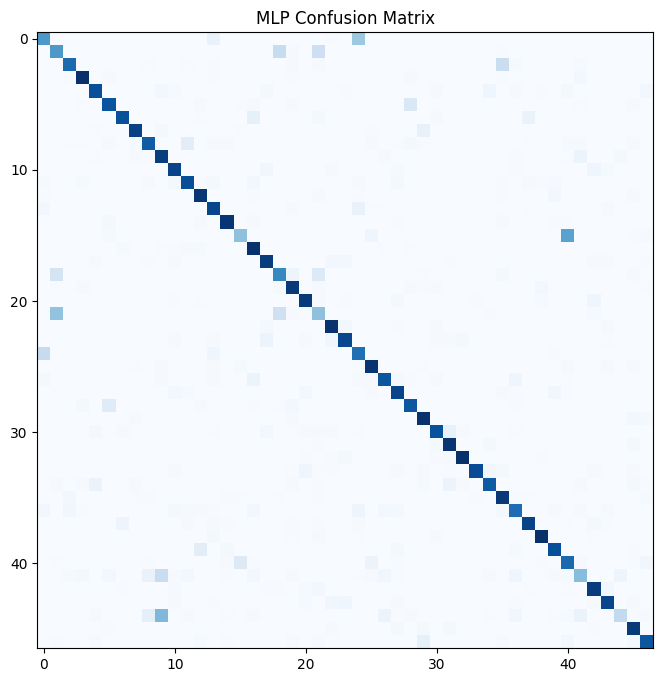

In [ ]:
# Evaluate the MLP and CNN models on the testing dataset

mlp_acc, mlp_cm = evaluate_MLP(mlp_model, test_loader)
cnn_acc, cnn_cm = evaluate_CNN(cnn_model, test_loader)

# Plot the MLP confusion matrix

plt.figure(figsize=(10, 8))
plt.title("MLP Confusion Matrix")
plt.imshow(mlp_cm, cmap='Blues')
plt.xticks(np.arange(len(label_map)), mapping, rotation=90)
plt.yticks(np.arange(len(label_map)), mapping)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the CNN confusion matrix

plt.figure(figsize=(10, 8))
plt.title("CNN Confusion Matrix")
plt.imshow(cnn_cm, cmap='Blues')
plt.xticks(np.arange(num_classes), mapping, rotation=90)
plt.yticks(np.arange(num_classes), mapping)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Step 6.4 - Summarize the performance of two models using accuracy, report the precision, recall and F1 score of MLP and CNNs

In [ ]:
# Evaluate MLP
print('MLP Performance:')
mlp_model.eval()
mlp_acc, mlp_cm = evaluate_MLP(mlp_model, test_loader)
print('Best MLP accuracy: {:.4f}'.format(mlp_acc))
print('Best MLP loss: {:.4f}'.format(min(mlp_losses)))
print('MLP confusion matrix:')
print(mlp_cm)
mlp_precision, mlp_recall, mlp_f1_score, _ = precision_recall_fscore_support(
    mlp_cm.argmax(axis=1), mlp_cm.argmax(axis=0), average='weighted')
print('MLP Precision: {:.4f}'.format(mlp_precision))
print('MLP Recall: {:.4f}'.format(mlp_recall))
print('MLP F1-score: {:.4f}'.format(mlp_f1_score))

# Evaluate CNN
print('CNN Performance:')
cnn_model.eval()
cnn_acc, cnn_cm = evaluate_CNN(cnn_model, test_loader)
print('Best CNN accuracy: {:.4f}'.format(cnn_acc))
print('Best CNN loss: {:.4f}'.format(min(cnn_losses)))
print('CNN confusion matrix:')
print(cnn_cm)
cnn_precision, cnn_recall, cnn_f1_score, _ = precision_recall_fscore_support(
    cnn_cm.argmax(axis=1), cnn_cm.argmax(axis=0), average='weighted')
print('CNN Precision: {:.4f}'.format(cnn_precision))
print('CNN Recall: {:.4f}'.format(cnn_recall))
print('CNN F1-score: {:.4f}'.format(cnn_f1_score))

MLP Performance:
Accuracy: 0.7944
Precision: 0.7993
Recall: 0.7944
F1-score: 0.7898
Best MLP accuracy: 0.7944
Best MLP loss: 0.8131
MLP confusion matrix:
[[224   0   0 ...   0   1   0]
 [  0 224   0 ...   0   1   1]
 [  0   0 291 ...   0   0   0]
 ...
 [  0   0   1 ...  98   2   3]
 [  0   0   0 ...   0 360   1]
 [  0   2   1 ...   0   7 320]]
MLP Precision: 1.0000
MLP Recall: 0.9574
MLP F1-score: 0.9716
CNN Performance:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
